# **Face De-Identification with Adversarial Attack**

In [1]:
!nvidia-smi

Tue Nov 16 02:48:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Clone repo & Download data

In [2]:
!git clone https://github.com/kaylode/mediaeval21-drsf.git main
%cd /content/main

Cloning into 'main'...
remote: Enumerating objects: 1105, done.
remote: Counting objects: 100% (1105/1105), done.
remote: Compressing objects: 100% (696/696), done.
remote: Total 1105 (delta 505), reused 953 (delta 371), pack-reused 0
Receiving objects: 100% (1105/1105), 76.93 MiB | 26.36 MiB/s, done.
Resolving deltas: 100% (505/505), done.
/content/main


In [3]:
%%capture
!pip install -r requirements.txt

In [4]:
%cd /content/main
!git reset --hard HEAD
!git pull

/content/main
HEAD is now at 5aaede7 fix some bugs in mtcnn (not entirely)
Already up to date.


In [5]:
%cd /content/
!mkdir data

import os
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='11fM-E36pJdzZQ4Q5O64lxhpFHER8dJPZ',
                                    dest_path='/content/data/data.zip',
                                    unzip=True)

os.remove('/content/data/data.zip')

gdd.download_file_from_google_drive(file_id='1zlLMJEDlYqKdRnp_TOwevCS33i4pt-ZU',
                                    dest_path='/content/data/data.zip',
                                    unzip=True)

os.remove('/content/data/data.zip')

/content
Unzipping...Done.
Unzipping...Done.


# De-ID

In [6]:
%cd /content/main
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from attack.deid import Pixelate, Blur
from models.face_align.fan import FANAlignment
from models.face_align.models.face_alignment.utils import crop
from models.face_det.retinaface import RetinaFaceDetector
from attack.attacker import generate_tensors
from attack.attacker.full_attacker import FullAttacker
from models.gaze_det.gaze import GazeModel
from utils.visualizer import Visualizer

/content/main


In [7]:
def crop_video(video_path, out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)
        
    cap = cv2.VideoCapture(video_path)
    idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            cv2.imwrite(f"{out_path}/{idx}.jpg", frame)
        else:
            break
        idx += 1

    if ret == True:
        cap.release()
 
    cv2.destroyAllWindows()

def visualize(image, face, gaze_model):
    visualizer = Visualizer(gaze_model._face3d.camera, gaze_model._face3d._face_model3d.NOSE_INDEX)
    visualizer.set_image(image)
    visualizer.draw_bbox(face.bbox)
    visualizer.draw_model_axes(face, 0.05, lw=2)
    euler_angles = face.head_pose_rot.as_euler("XYZ", degrees=True)
    pitch, yaw, roll = face.change_coordinate_system(euler_angles)
    visualizer.draw_points(face.landmarks, color=(0, 255, 255), size=1)
    visualizer.draw_3d_line(face.center, face.center + 0.05 * face.gaze_vector)
    visualizer.draw_3d_points(face.model3d, color=(255, 0, 525), size=1)

    return visualizer.image

In [8]:
def inference(images, det_model, align_model=None, gaze_model=None):
    # inference models on images

    # Get detection results
    results_norm = det_model.preprocess(images)
    results_norm = generate_tensors(results_norm)
    det_results = det_model.detect(results_norm)
    face_boxes = det_model.get_face_boxes(det_results)

    # Use mask to filter out empty boxes 
    masks = [0 if len(box) == 0 else 1 for box in face_boxes]
    masked_face_boxes = [box for box, mask in zip(face_boxes, masks) if mask == 1]
    masked_images = [image for image, mask in zip(images, masks) if mask == 1]

    face_boxes = [box if mask == 1 else [0,0,0,0] for box, mask in zip(face_boxes, masks)]

    if align_model is None:
        return face_boxes

    # Get alignment results
    centers, scales = align_model._get_scales_and_centers(masked_face_boxes)
    lm_norm = align_model.preprocess(masked_images, centers, scales)
    lm_norm = generate_tensors(lm_norm)
    _, masked_landmarks = align_model.detect(lm_norm, centers, scales)

    masked_landmarks = [lm.numpy() for lm in masked_landmarks]
    # Mask empty prediction
    landmarks = [lm if mask == 1 else np.zeros((68,2)) for lm, mask in zip(masked_landmarks, masks)]

    if gaze_model is None:
        return face_boxes, landmarks

    gaze_norm, faces = gaze_model.preprocess(images, masked_face_boxes, masked_landmarks, return_faces=True)
    gaze_results = gaze_model.detect(gaze_norm)
    gaze_centers, gaze_vectors = gaze_model.get_gaze_vector(gaze_results, faces)

    return faces

In [9]:
def deid(batch, det_model, align_model, deid_fn):

    # Generate truth bboxes
    det_norm = det_model.preprocess(batch)
    det_norm = generate_tensors(det_norm)
    det_results = det_model.detect(det_norm)
    face_boxes = det_model.get_face_boxes(det_results)

    # Check if a box is empty, if so, use previous box or next box
    for idx, box in enumerate(face_boxes):
        if len(box) == 0:
           face_boxes[idx] = face_boxes[idx-1][:]

    # Generate deid images
    centers, scales = align_model._get_scales_and_centers(face_boxes)
    adv_images = []
    for cv2_image, center, scale in zip(batch, centers, scales):
        _, old_box, _, _ = crop(cv2_image.copy(), center, scale, return_points=True)
        deid_image = deid_fn(cv2_image.copy(), old_box)
        adv_images.append(deid_image)

    return adv_images


def attack(batch, adv_images, attacker, victims):

    adv_imgs = attacker.attack(
        victims = victims, 
        images = batch, 
        deid_images = adv_images)
    
    return adv_imgs

In [10]:
VIDEO_NAME = "T002_ActionsShorter_mini_12682_13352_Dance-Sing"
ACTION_NAME = VIDEO_NAME.split('_')[-1]
VIDEO_PATH = f"/content/data/Level 1_actions/{ACTION_NAME}/{VIDEO_NAME}.mp4"
CSV_PATH = f"/content/data/RetinaFaceDetections/Level 1/{VIDEO_NAME}.csv"

CAP = cv2.VideoCapture(VIDEO_PATH)
WIDTH = int(CAP.get(cv2.CAP_PROP_FRAME_WIDTH))  # float `width`
HEIGHT = int(CAP.get(cv2.CAP_PROP_FRAME_HEIGHT))  # float `height`
CAP.release()

if not os.path.exists(f"/content/frames/{VIDEO_NAME}"):
    crop_video(VIDEO_PATH, f"/content/frames/{VIDEO_NAME}")

In [22]:
# Init models, attackers

align_model = FANAlignment()
det_model = RetinaFaceDetector()
gaze_model = GazeModel('ETH-XGaze', WIDTH, HEIGHT)
attacker = FullAttacker('rmsprop', max_iter=100)
deid_fn = Pixelate(30)

Missing keys:0
Unused checkpoint keys:0
Used keys:300


## On image (batch attack)

In [ ]:
# Read images into batch
BATCH_SIZE = 4
cv2_images = []
for frame_id in tqdm(range(BATCH_SIZE)):
    input_img = cv2.imread(f"/content/frames/{VIDEO_NAME}/{frame_id}.jpg")
    cv2_image = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
    cv2_images.append(cv2_image)

100%|██████████| 4/4 [00:00<00:00, 182.78it/s]


- Ground truth

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


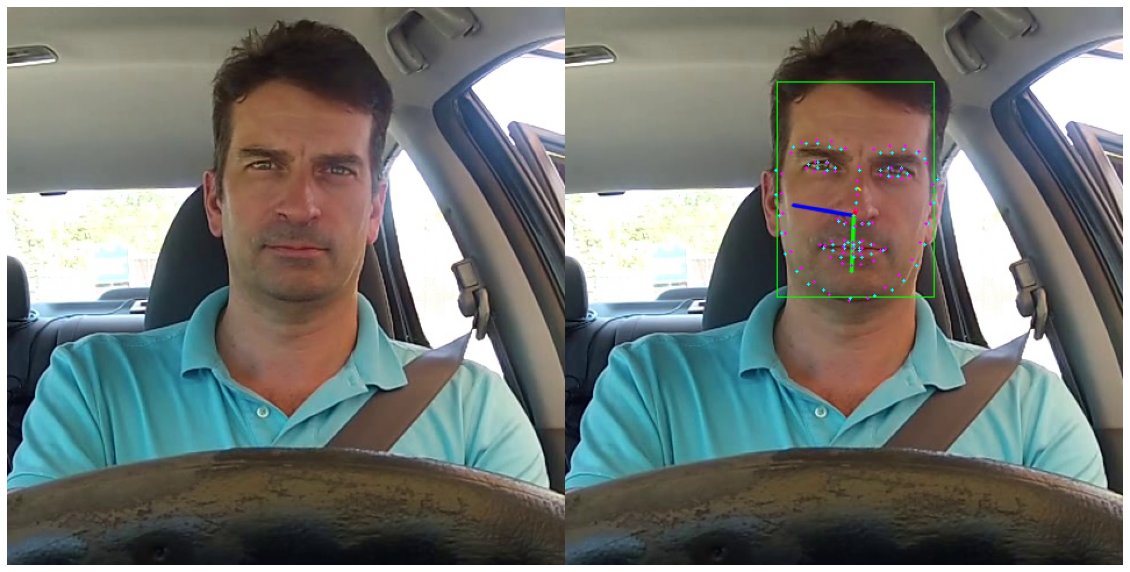

In [ ]:
# Get faces
faces = inference(cv2_images, det_model, align_model, gaze_model)

bid = 0
image = cv2_images[bid].copy()
face = faces[bid]

result = visualize(image, face, gaze_model)

plt.figure(figsize=(20,20))
plt.axis("off")
concat = np.concatenate([cv2_images[bid].copy(), result], axis=1)
plt.imshow(concat)

- Non-Attacked de-identified image 

In [ ]:
deid_images = deid(cv2_images, det_model, align_model, deid_fn)
faces = inference(deid_images, det_model, align_model, gaze_model)

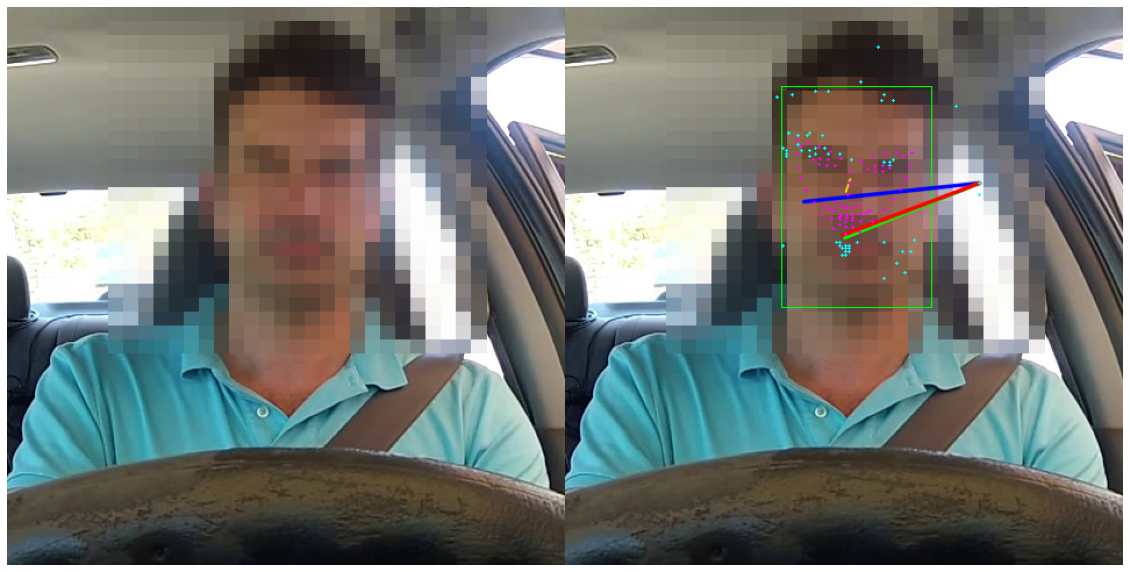

In [ ]:
bid = 0
image = deid_images[bid].copy()
face = faces[bid]

result = visualize(image, face, gaze_model)

plt.figure(figsize=(20,20))
plt.axis("off")
concat = np.concatenate([deid_images[bid].copy(), result], axis=1)
plt.imshow(concat)

- Attacked de-identified image 

In [ ]:
adv_images = attack(cv2_images, deid_images, attacker, 
                     victims = {
                         'detection': det_model,
                         'alignment': align_model,
                         'gaze': gaze_model
                     })

faces = inference(adv_images, det_model, align_model, gaze_model)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Number of iter:  100


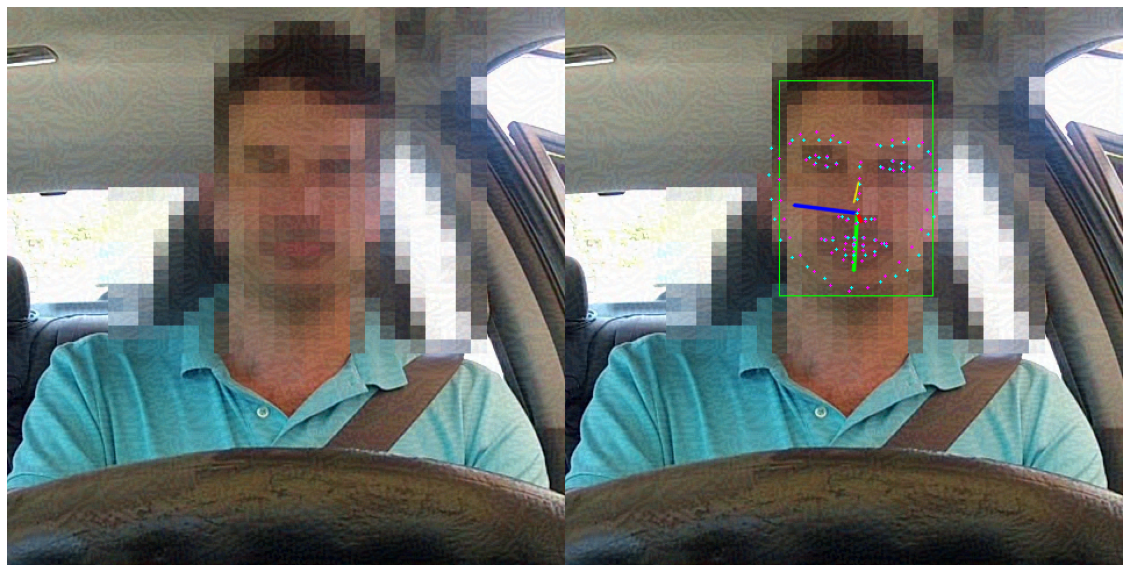

In [ ]:
bid = 0
image = adv_images[bid].copy()
face = faces[bid]

result = visualize(image, face, gaze_model)

plt.figure(figsize=(20,20))
plt.axis("off")
concat = np.concatenate([adv_images[bid].copy(), result], axis=1)
plt.imshow(concat)

### Evaluation

In [ ]:
from attack.attacker import generate_tensors
from sklearn.metrics.pairwise import paired_euclidean_distances, paired_cosine_distances

def calc_iou(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou


class Evaluator:
    def __init__(self, det_model, align_model=None, gaze_model=None):
        self.det_model = det_model
        self.align_model = align_model
        self.gaze_model = gaze_model

    def _evaluate_detection(self, frame1, frame2):
        results_norm = self.det_model.preprocess([frame1, frame2])
        results_norm = generate_tensors(results_norm)
        det_results = self.det_model.detect(results_norm)
        face_boxes = self.det_model.get_face_boxes(det_results)

        iou_score = calc_iou(face_boxes[0], face_boxes[1])
        return iou_score, face_boxes

    def _evaluate_alignment(self, frame1, frame2, bboxes):
        centers, scales = self.align_model._get_scales_and_centers(bboxes)
        lm_norm = self.align_model.preprocess([frame1, frame2], centers, scales)
        lm_norm = generate_tensors(lm_norm)
        _, landmarks = self.align_model.detect(lm_norm, centers, scales)

        landmarks = [lm.numpy() for lm in landmarks]

        dist = paired_euclidean_distances(landmarks[0], landmarks[1]).mean()
        return dist, landmarks

    def _evaluate_gaze(self, frame1, frame2, bboxes, landmarks):
        gaze_norm, faces = self.gaze_model.preprocess([frame1, frame2], bboxes, landmarks, return_faces=True)
        gaze_results = self.gaze_model.detect(gaze_norm)
        
        for face, gaze_vector in zip(faces, gaze_results):
            self.gaze_model._face3d.postprocess([gaze_vector], face)

        euler_angles1 = faces[0].head_pose_rot.as_euler("XYZ", degrees=True).reshape((1, 3))
        euler_angles2 = faces[1].head_pose_rot.as_euler("XYZ", degrees=True).reshape((1, 3))

        cosine_dist = paired_cosine_distances(euler_angles1, euler_angles2).mean()

        return cosine_dist

    def evaluate(self, frame1, frame2):

        eval_results = {}
        iou_score, bboxes = self._evaluate_detection(frame1, frame2)
        eval_results['iou'] = iou_score

        if self.align_model is not None:
            lm_dist, landmarks = self._evaluate_alignment(frame1, frame2, bboxes)
            eval_results['lm_edist'] = lm_dist

        if self.gaze_model is not None:
            gaze_dist = self._evaluate_gaze(frame1, frame2, bboxes, landmarks)
            eval_results['gaze_cosine'] = gaze_dist

        return eval_results

In [ ]:
bid = 2
adv_frame = adv_images[bid].copy()
raw_frame = cv2_images[bid].copy()

evaluator = Evaluator(det_model, align_model, gaze_model)
results = evaluator.evaluate(adv_frame, raw_frame)
print(results)

{'iou': 0.9540719696969697, 'lm_dist': 8.223582, 'gaze_cosine': 0.14965161427749932}


## On video (batch attack)

In [ ]:
import torch
from torchvision.transforms import functional as TFF
from tqdm import tqdm

In [ ]:
cap = cv2.VideoCapture(VIDEO_PATH)
WIDTH  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # float `width`
HEIGHT = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # float `height`
FPS = int(cap.get(cv2.CAP_PROP_FPS))
NUM_FRAMES = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
batch_size = 16

outvid = cv2.VideoWriter(f'/content/{VIDEO_NAME}_deid_viz.avi', cv2.VideoWriter_fourcc('M','J','P','G'), FPS, (WIDTH,HEIGHT))
outvid2 = cv2.VideoWriter(f'/content/{VIDEO_NAME}_deid.avi', cv2.VideoWriter_fourcc('M','J','P','G'), FPS, (WIDTH,HEIGHT))

batch = []
for frame_id in tqdm(range(NUM_FRAMES)):
    if os.path.exists(f"/content/frames/{VIDEO_NAME}/{frame_id}.jpg"):
        input_img = cv2.imread(f"/content/frames/{VIDEO_NAME}/{frame_id}.jpg")
        cv2_image = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
        batch.append(cv2_image)

    if (len(batch)+1) % batch_size == 0 or frame_id==NUM_FRAMES-1:

        deid_images = deid(batch, det_model, align_model, deid_fn)
        adv_images = attack(batch, deid_images, attacker, 
                            victims = {
                                'detection': det_model,
                                'alignment': align_model,
                                'gaze': gaze_model
                            })
        faces = inference(adv_images, det_model, align_model, gaze_model)

        batch = []

        for adv_img, face in zip(adv_images, faces):
            image = adv_img.copy()
            result = visualize(image, face, gaze_model)
            image = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
            outvid.write(image)
  
        for adv_img in adv_images:
            image = adv_img.copy()
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
            outvid2.write(image)

In [ ]:
!cp "/content/T004_ActionsShorter_Face_3289_3359_Cough-Sneeze_deid.avi" -d "/content/drive/MyDrive/AI/Weights/safety-driving-road/pixelate-attack/baseline2"

# Scripts

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
INPUT_FOLDER      =  "/content/data/Level1_actions/Cough-Sneeze" #@param {type:"string"}
OUTPUT_FOLDER     =  "/content/drive/MyDrive/AI/Weights/safety-driving-road/pixelate-attack" #@param {type:"string"}
DETECTOR          =  'retinaface' #@param ["retinaface", "mtcnn"]
ALIGNMENT         =  'fan' #@param ["fan"]
GAZE              =  'ETH-XGaze' #@param ["ETH-XGaze", "MPIIFaceGaze"]
ALGORITHM         =  'rmsprop' #@param ["rmsprop", "i-fgsm", "mi-fgsm"]
DEID              =  'pixelate' #@param ["pixelate", "blur"]
MAX_ITER          =  150 #@param {type:"integer"}
BATCH_SIZE        =  16 #@param {type:"integer"}




In [ ]:
import os
from tqdm import tqdm
video_names = os.listdir(INPUT_FOLDER)
video_paths = [os.path.join(INPUT_FOLDER, i) for i in video_names]

In [ ]:
%cd main

for video_path in video_paths:
    !python run.py  -i $video_path \
                    -o . \
                    -d $DETECTOR \
                    -a $ALIGNMENT \
                    -z $GAZE \
                    -g $ALGORITHM \
                    --max_iter $MAX_ITER \
                    -bs $BATCH_SIZE

    video_name = os.path.basename(video_path)
    output_video = os.path.join('/content/', f'{video_name}_deid_viz.avi')
    output_video2 = os.path.join('/content/', f'{video_name}_deid.avi')

    !cp $output_video -d $OUTPUT_FOLDER
    !cp $output_video2 -d $OUTPUT_FOLDER

/content/main
Missing keys:0
Unused checkpoint keys:0
Used keys:300
  0% 0/90 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
Num iter:  6
 18% 16/90 [07:14<33:28, 27.14s/it]Num iter:  5
 36% 32/90 [13:08<23:23, 24.19s/it]Num iter:  8
 53% 48/90 [22:09<20:00, 28.59s/it]